# California Housing Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import geopandas as gpd
import seaborn as sns

from libpysal.weights import DistanceBand, KNN
from esda.moran import Moran
from spreg import OLS, ML_Error, ML_Lag, GM_Error, GM_Lag
from scipy import stats
from shapely.geometry import Point
from splot.esda import moran_scatterplot, plot_moran
import contextily as ctx
from matplotlib.ticker import FuncFormatter
import pyproj
from libpysal.weights import lag_spatial
from scipy.stats import norm

In [2]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing(as_frame=True)
df = data.frame

The California Housing dataset originates from the 1990 U.S. Census. Each observation represents a census block group. The dataset contains 20,640 observations with no missing values. 

The key research question is:

*"What is the influencing factors of the median house value in a census block group?"*

## Data Source

The dataset is built into scikit-learn and can be loaded directly without downloading:

## Variables

| Variable | Type | Description |
|---|---|---|
| `MedHouseVal` | Dependent (Y) | Median house value in block group (units: $100,000) |
| `MedInc` | Socioeconomic | Median household income in block group (units: tens of thousands of dollars) |
| `HouseAge` | Housing stock | Median age of houses in block group (years) |
| `AveRooms` | Housing stock | Average number of rooms per household |
| `AveBedrms` | Housing stock | Average number of bedrooms per household |
| `Population` | Demographic | Total population of block group |
| `AveOccup` | Demographic | Average number of occupants per household |
| `Latitude` | Location | Block group centroid latitude |
| `Longitude` | Location | Block group centroid longitude |


In [ ]:
df = df[['MedHouseVal', 'Latitude','Longitude','MedInc','HouseAge' ,'AveRooms', 'AveBedrms', 'Population', 'AveOccup', ]]
df['census_block'] = df.index +1
df = df[['census_block','MedHouseVal', 'Latitude','Longitude','MedInc','HouseAge' ,'AveRooms', 'AveBedrms', 'Population', 'AveOccup']]
df.head()

,MedHouseVal,Latitude,Longitude,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,2.068558,35.631861,-119.569704,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655
std,1.153956,2.135952,2.003532,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050
min,0.149990,32.540000,-124.350000,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308
25%,1.196000,33.930000,-121.800000,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741
50%,1.797000,34.260000,-118.490000,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116
75%,2.647250,37.710000,-118.010000,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261
max,5.000010,41.950000,-114.310000,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333


#### Draw a boxplot for all variables in the dataframe to examine outliers.

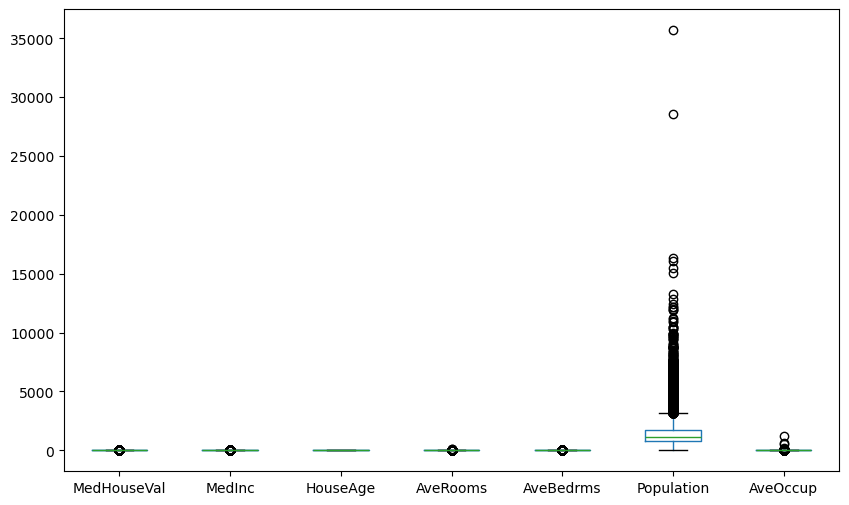

In [5]:
boxplot = df.boxplot(column=['MedHouseVal', 'MedInc', 'HouseAge' ,'AveRooms', 'AveBedrms', 'Population', 'AveOccup'],
                     grid=False, figsize=(10, 6))


#### Population variable has considerable outliers, produce a histogram to inspect further:

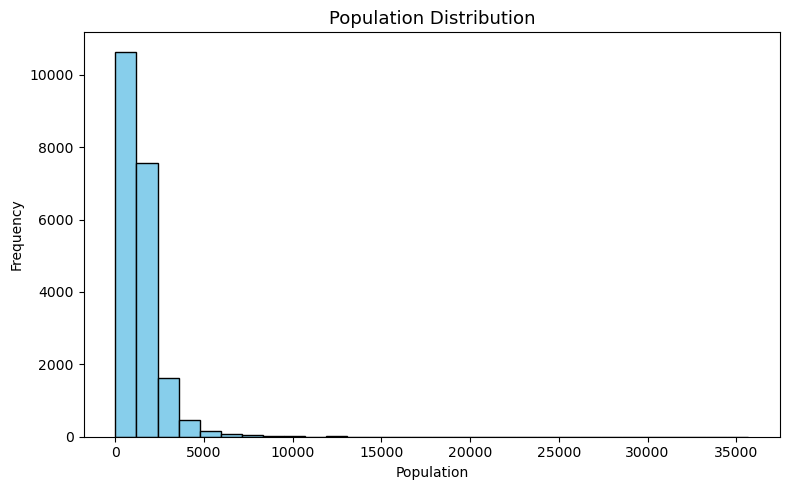

In [7]:
# explore population outliers
fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(df['Population'], bins=30, edgecolor='black', color='skyblue')
ax.set_title('Population Distribution', fontsize=13)
ax.set_xlabel('Population')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [8]:
## Limit Population to 95th percentile:
pop_95th = df['Population'].quantile(0.95)
print(f"95th percentile of Population: {pop_95th}")
df = df[df['Population'] <= pop_95th]
print(f"Number of blocks after removing population outliers: {len(df)}")

## Limit Rooms:
df = df[df['AveRooms'] <= 10]
print(f"Number of blocks after removing Room  outliers: {len(df)}")

## Limit Occupancy:
df = df[df['AveOccup'] <= 5]
print(f"Number of blocks after removing occupancy outliers: {len(df)}")

## Limit Bedrroms:
df = df[df['AveBedrms'] <= 2]
print(f"Number of blocks after removing bedroom outliers: {len(df)}")   

## Limit House Values:
df = df[df['MedHouseVal'] <= 5]
print(f"Number of blocks after removing house value outliers: {len(df)}")

95th percentile of Population: 3288.0
Number of blocks after removing population outliers: 19609
Number of blocks after removing Room  outliers: 19384
Number of blocks after removing occupancy outliers: 19089
Number of blocks after removing bedroom outliers: 19046
Number of blocks after removing house value outliers: 18128


#### Visualise distribution of house values before and after log transformation, check which one is more suitable:


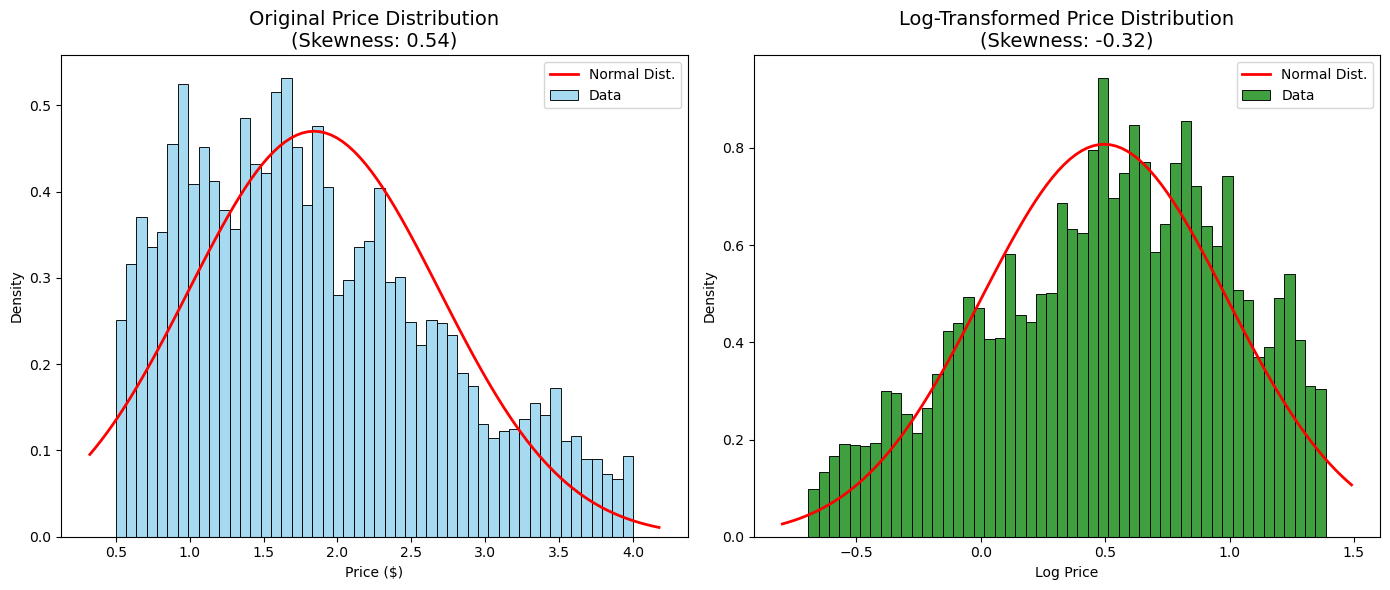

In [ ]:
value = df['MedHouseVal']
log_value = np.log(df['MedHouseVal'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Plot A: Original Price ---
sns.histplot(value, bins=50, kde=False, color='skyblue', stat='density', ax=axes[0], label='Data')
# Overlay Normal Curve (based on original mean/std)
mu, std = norm.fit(value)
xmin, xmax = axes[0].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
axes[0].plot(x, p, 'r', linewidth=2, label='Normal Dist.')

axes[0].set_title(f'Original Price Distribution\n(Skewness: {value.skew():.2f})', fontsize=14)
axes[0].set_xlabel('Price ($)')
axes[0].legend()

# --- Plot B: Log Transformed Price ---
sns.histplot(log_value, bins=50, kde=False, color='green', stat='density', ax=axes[1], label='Data')
# Overlay Normal Curve (based on log mean/std)
mu_log, std_log = norm.fit(log_value)
xmin, xmax = axes[1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_log, std_log)
axes[1].plot(x, p, 'r', linewidth=2, label='Normal Dist.')

axes[1].set_title(f'Log-Transformed Price Distribution\n(Skewness: {log_value.skew():.2f})', fontsize=14)
axes[1].set_xlabel('Log Price')
axes[1].legend()

plt.tight_layout()
plt.show()

#### Looks like there is skewness in the data, limit the outliers and try again:

Number of blocks after further limiting house values: 17209


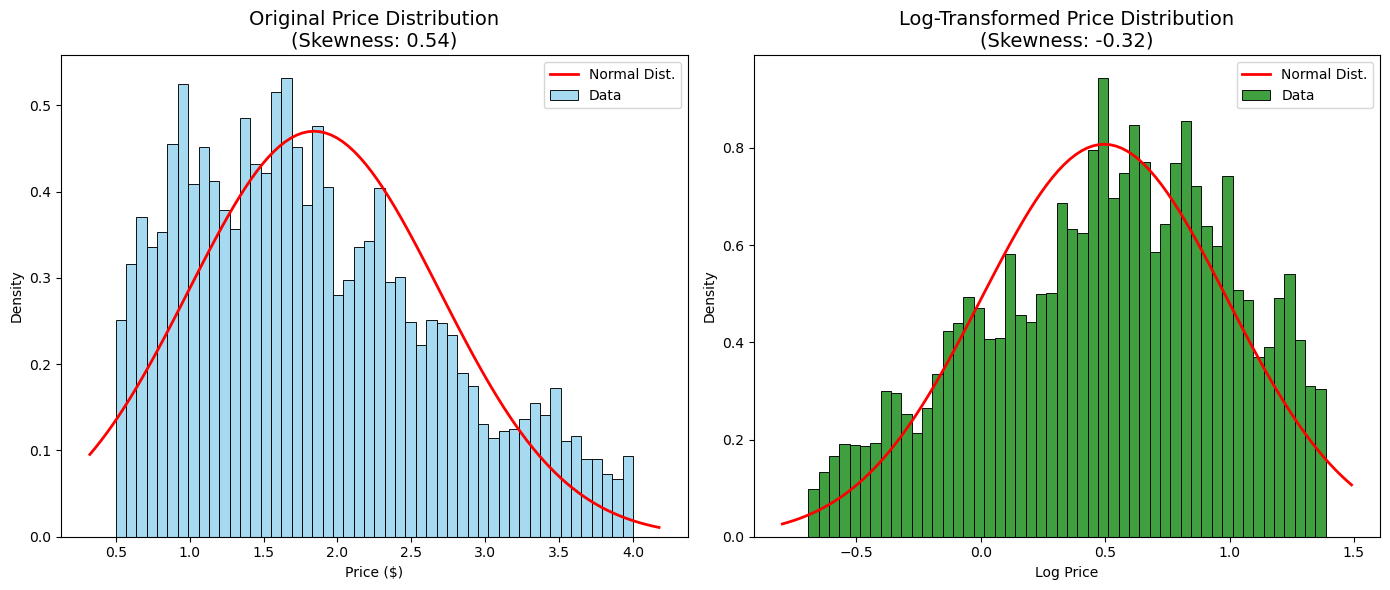

In [ ]:
df_copy = df[(df['MedHouseVal'] <= 4) & (df['MedHouseVal'] >= 0.5)].copy()
print(f"Number of blocks after further limiting house values: {len(df_copy)}")

value = df_copy['MedHouseVal']
log_value = np.log(df_copy['MedHouseVal'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Plot A: Original Price ---
sns.histplot(value, bins=50, kde=False, color='skyblue', stat='density', ax=axes[0], label='Data')
# Overlay Normal Curve (based on original mean/std)
mu, std = norm.fit(value)
xmin, xmax = axes[0].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
axes[0].plot(x, p, 'r', linewidth=2, label='Normal Dist.')

axes[0].set_title(f'Original Price Distribution\n(Skewness: {value.skew():.2f})', fontsize=14)
axes[0].set_xlabel('Price ($)')
axes[0].legend()

# --- Plot B: Log Transformed Price ---
sns.histplot(log_value, bins=50, kde=False, color='green', stat='density', ax=axes[1], label='Data')
# Overlay Normal Curve (based on log mean/std)
mu_log, std_log = norm.fit(log_value)
xmin, xmax = axes[1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_log, std_log)
axes[1].plot(x, p, 'r', linewidth=2, label='Normal Dist.')

axes[1].set_title(f'Log-Transformed Price Distribution\n(Skewness: {log_value.skew():.2f})', fontsize=14)
axes[1].set_xlabel('Log Price')
axes[1].legend()

plt.tight_layout()
plt.show()

#### Now, log transformation has made the distribution more normal. So take this as our dependent variable for regression:

In [37]:
df_copy['log_MedHouseVal'] = np.log(df_copy['MedHouseVal'])
df_copy = df_copy.drop(columns=['MedHouseVal'])
df_updated = df_copy.copy()

#### Create a map of log values. Resulting plot shows clear spatial autocorrelation where house values in census tracts nearer the west coast are greater than those than are located in inland California.

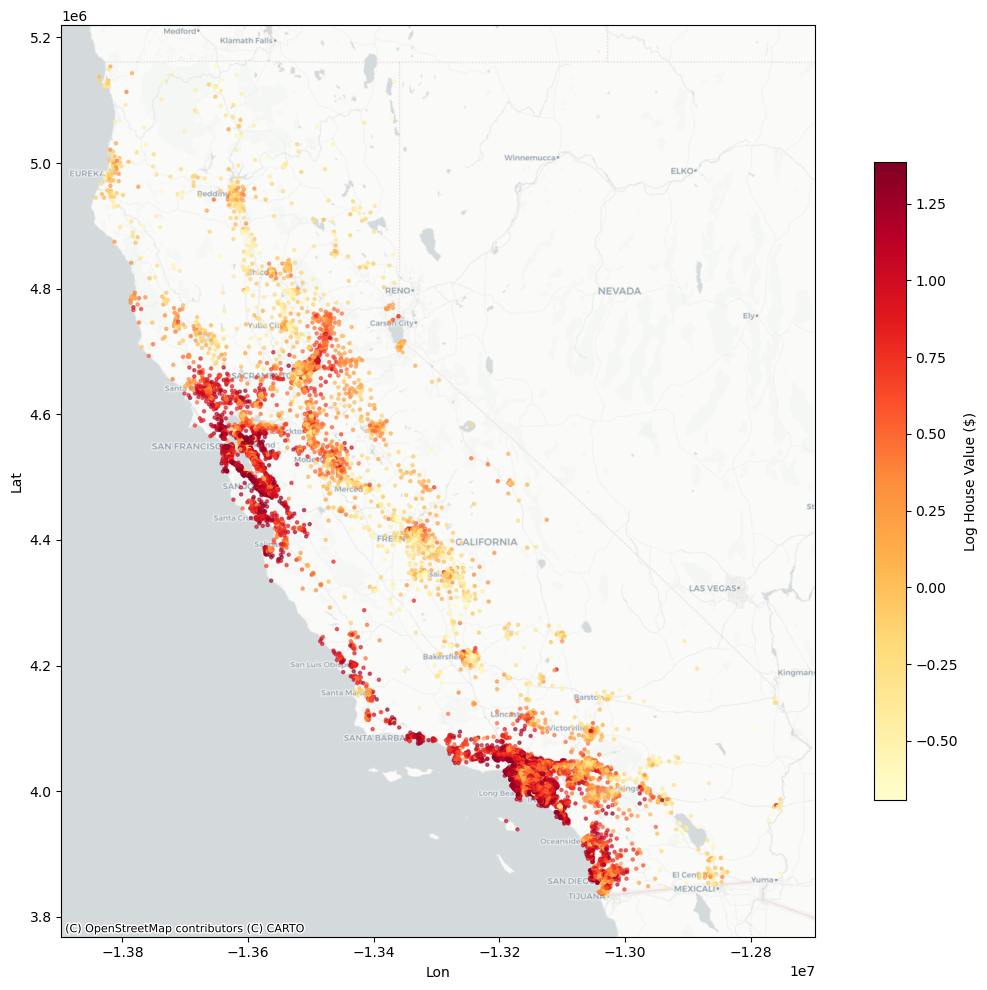

In [35]:
geometry = [Point(xy) for xy in zip(df_updated['Longitude'], df_updated['Latitude'])]
gdf = gpd.GeoDataFrame(df_updated, geometry=geometry, crs='EPSG:4326')
gdf.head()

gdf_web = gdf.to_crs('EPSG:3857')

fig, ax = plt.subplots(figsize=(12, 10))

gdf_web.plot(
    ax=ax, column='log_MedHouseVal', cmap='YlOrRd',
    markersize=5, alpha=0.6, legend=True,
    legend_kwds={'label': 'Log House Value ($)', 'shrink': 0.7}
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_xlabel('Lon')
ax.set_ylabel('Lat')

transformer = pyproj.Transformer.from_crs('EPSG:3857', 'EPSG:4326', always_xy=True)

plt.tight_layout()
plt.show()

#### Before diving into regression analysis, we take a look at which variables may be correlated with each other. Keeping an eye on multicolinearity.

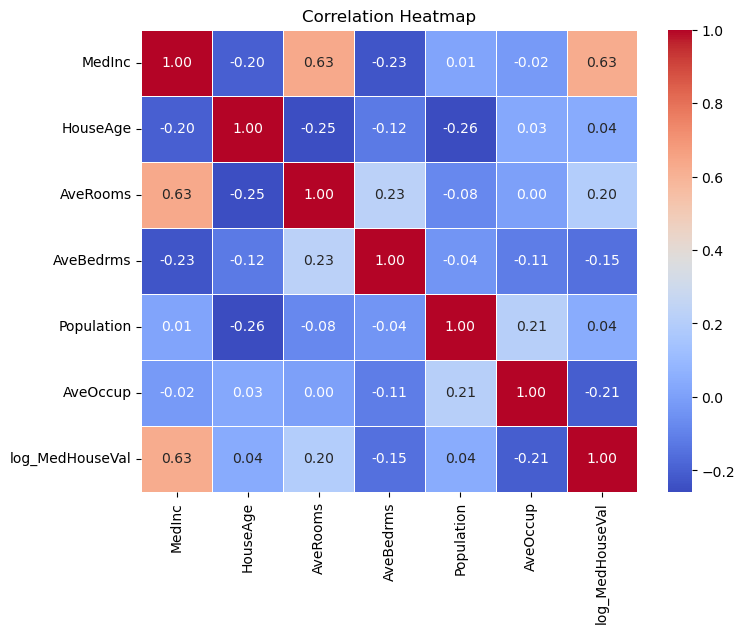

Looks like average number of rooms and median income have a strong positive correlation.
Check VIF values to see if this is a problem for regression.


In [43]:
matrix = df_updated[['MedInc', 'HouseAge','AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'log_MedHouseVal']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

print("Looks like average number of rooms and median income have a strong positive correlation.\nCheck VIF values to see if this is a problem for regression.")

In [ ]:
# VIF Check for Multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe of just the independent variables (X)
x_cols = ['MedInc', 'HouseAge','AveRooms', 'AveBedrms', 'Population', 'AveOccup']
X_vif = df_updated[x_cols] 

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("Variance Inflation Factor (VIF) Check:")
print("-" * 40)
print(vif_data.sort_values('VIF', ascending=False))
print("-" * 40)

Variance Inflation Factor (VIF) Check:
----------------------------------------
     Variable        VIF
2    AveRooms  51.408481
3   AveBedrms  44.922028
5    AveOccup  18.407589
0      MedInc  13.683685
1    HouseAge   6.582671
4  Population   5.272618
----------------------------------------
Note: VIF > 10 indicates high multicollinearity that may distort spatial coefficients.


#### High multicollinearity here, remove AveBedrms, AveOccup and AveRooms as they conincide with each other and are likely to correlate with income, and we know that income is more strongly correlated with house value from the above correlation matrix.

In [65]:
x_cols = ['MedInc', 'HouseAge','Population']
X_vif = df_updated[x_cols] 

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("Variance Inflation Factor (VIF) Check:")
print("-" * 40)
print(vif_data.sort_values('VIF', ascending=False))
print("-" * 40)

Variance Inflation Factor (VIF) Check:
----------------------------------------
     Variable       VIF
0      MedInc  4.264508
2  Population  3.374616
1    HouseAge  3.364559
----------------------------------------


#### Now that multicollinearity has been dealt with, we can focus on regression. First make the Spatial Weight Matrix, W, and then perform simple OLS:

In [ ]:
# Extract projected coordinates for distance calculations
gdf_proj = gdf.to_crs('EPSG:27700')
coords = np.column_stack((gdf_proj.geometry.x, gdf_proj.geometry.y))

# ---- KNN Weight Matrix ----
w_knn = KNN.from_array(coords, k=12)
# K = 12 as some blocks are large and may become islands and low K values.
w_knn.transform = 'R'  # Row-standardise

print("=== KNN Spatial Weights (k=12) ===")
print(f"Number of observations: {w_knn.n}")
print(f"Mean number of neighbours: {w_knn.mean_neighbors:.1f}")
print(f"Min neighbours: {w_knn.min_neighbors}")
print(f"Max neighbours: {w_knn.max_neighbors}")

=== KNN Spatial Weights (k=10) ===
Number of observations: 17209
Mean number of neighbours: 12.0
Min neighbours: 12
Max neighbours: 12


In [ ]:
y_col = 'log_MedHouseVal' 
y = df_updated[y_col].values
x = df_updated[x_cols].values

ols = OLS(
    y, x,
    w=w_knn,
    name_y=y_col,
    name_x=x_cols,
    name_ds='California Housing Census Blocks',
    spat_diag=True  # Request spatial diagnostics including LM tests
)

print(ols.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :Bristol Airbnb
Weights matrix      :     unknown
Dependent Variable  :log_MedHouseVal                Number of Observations:       17209
Mean dependent var  :      0.4961                Number of Variables   :           4
S.D. dependent var  :      0.4941                Degrees of Freedom    :       17205
R-squared           :      0.4269
Adjusted R-squared  :      0.4268
Sum squared residual:      2408.1                F-statistic           :   4272.0529
Sigma-square        :       0.140                Prob(F-statistic)     :           0
S.E. of regression  :       0.374                Log likelihood        :   -7496.950
Sigma-square ML     :       0.140                Akaike info criterion :   15001.899
S.E of regression ML:      0.3741                Schwarz criterion     :   15032.912

-------------------------------------------------------

In [67]:
# Moran's I test for spatial autocorrelation in OLS residuals
residuals = ols.u.flatten()
moran = Moran(residuals, w_knn)

print("=== Global Moran's I Test on OLS Residuals ===")
print(f"Moran's I:     {moran.I:.4f}")
print(f"Expected I:    {moran.EI:.4f}")
print(f"Z-score:       {moran.z_sim:.4f}")
print(f"P-value:       {moran.p_sim:.4f}")
print()

=== Global Moran's I Test on OLS Residuals ===
Moran's I:     0.6336
Expected I:    -0.0001
Z-score:       220.2023
P-value:       0.0010



#### Morans I is positive and P-value is statistically significant such that the null hypothesis of randomly distributed values and clustering is by chance, is rejected.